In [1]:
import xarray as xr
import pandas as pd
from geopandas import gpd
#import fiona

import numpy as np
from dask.distributed import Client, wait
from dask import array as darr

from pathlib import Path

import hextraj

from matplotlib import pyplot as plt
import cartopy
import seaborn as sns

## Parameters

We need to specify the hex projectoin.  The relevant parameters are stored in the connectivity matrix dataset.

In [2]:
connectivity_matrix_file_path = "/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/020_connection_count_05m/"
connectivity_matrix_file_pattern = "020_connection_count_05m_days-travelled-??.nc"

connectivity_matrix_file_out_path = "/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/"
connectivity_matrix_file_out_pattern = "030_connection_count_05m_days-travelled-{dt:02d}_bio_agg.nc"

In [ ]:
connectivity_matrix_file_list = sorted(Path(connectivity_matrix_file_path).glob(connectivity_matrix_file_pattern))
connectivity_matrix_file_list

[PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/020_connection_count_05m/020_connection_count_05m_days-travelled-00.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/020_connection_count_05m/020_connection_count_05m_days-travelled-01.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/020_connection_count_05m/020_connection_count_05m_days-travelled-02.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/020_connection_count_05m/020_connection_count_05m_days-travelled-03.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/020_connection_count_05m/020_connection_count_05m_days-travelled-04.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/020_connection_count_05m/020_connection_count_05m_days-travelled-05.nc'),
 PosixPath('/gxfs_work/geomar/smom

In [4]:
connectivity_matrix = xr.open_dataset(
    connectivity_matrix_file_list[0],
    chunks="auto"
)

connectivity_matrix

<xarray.Dataset> Size: 11GB
Dimensions:           (month: 5, year: 4, hex0: 8354, hex1: 8372, corner: 7)
Coordinates:
  * month             (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year              (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0_corners  (corner, hex0) float64 468kB dask.array<chunksize=(7, 8354), meta=np.ndarray>
    lat_hex0_corners  (corner, hex0) float64 468kB dask.array<chunksize=(7, 8354), meta=np.ndarray>
    lon_hex1_corners  (corner, hex1) float64 469kB dask.array<chunksize=(7, 8372), meta=np.ndarray>
    lat_hex1_corners  (corner, hex1) float64 469kB dask.array<chunksize=(7, 8372), meta=np.ndarray>
  * hex0              (hex0) <U14 468kB '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1              (hex1) <U14 469kB '(-15, -22, 37)' ... '(50, -22, -28)'
Dimensions without coordinates: corner
Data variables:
    obs               (month, year, hex0, hex1) float64 11GB dask.array<chunksize=(1, 1, 4089, 4100), meta=np.ndarray>
Attributes:
    hex_proj__lon_origin:       -3.0
    hex_proj__lat_origin:       54.5
    hex_proj__hex_size_meters:  10000

In [5]:
lon_origin = connectivity_matrix.attrs["hex_proj__lon_origin"]
lat_origin = connectivity_matrix.attrs["hex_proj__lat_origin"]

hex_size_meters = connectivity_matrix.attrs["hex_proj__hex_size_meters"]

## Create the hex projection and label all positions

Labelling is done lazily (no labels actually computed until we really request values).

In [ ]:
hex_proj = hextraj.HexProj(
    lon_origin=lon_origin,
    lat_origin=lat_origin,
    hex_size_meters=hex_size_meters,
)

display(hex_proj)

/opt/conda/envs/parcels/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Load biodata

### Aquaculture, Population, Diseases, Restoration

In [ ]:
def load_aqc_data(filename):
    df = pd.read_csv(filename, delimiter=";")

    return df

In [8]:
def load_pop_data(filename):
    df = pd.read_csv(filename, delimiter=";")

    return df

In [9]:
def load_rst_data(filename):
    df = pd.read_csv(filename, delimiter=";")

    return df

In [10]:
def load_his_data(filename):
    df = pd.read_csv(filename, delimiter=";")

    return df

In [11]:
def load_dss_data(filename):
    df = pd.read_csv(filename, delimiter=";")
    df["infected"] = df["status"].str.contains("infect")

    return df

In [12]:
def add_hex_labels(df, hex_proj):
    df["hex"] = hex_proj.lon_lat_to_hex_AoS(df.lon, df.lat)
    df["hex"] = df["hex"].apply(str)
    return df

In [13]:
df_aqc = add_hex_labels(
    load_aqc_data("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/data/config/Ostreaedulis_aquaculture_EMODnet.csv"),
    hex_proj,
)
df_aqc.head(5)

,lon,lat,OBJECTID,COUNTRY,OWNER_NAME,AREA_NAME,STATUS,FARM_TYPE,PRODUCTION_METHOD,PRODUCTION_STAGE,SPECIES,PURPOSE,PRODUCTS_DETAIL,POINT_INFO,POINT_DEFINITION,SITE_ID,COAST_DIST_M,POSITION_COASTLINE,hex
0,4.904483,60.517350,1676,Norway,"SCALMARIN AS, SCALPRO AS",n.a.,Active,Mixed (other),n.a.,"Broodstock, Grow out for human consumption, Ha...",European flat oyster,Commercial,"Ballan wrasse, Blue mussel, Islandic scallop, ...",Original,Farm,NW_0038,0.053301,Within the coastline,"(29, 26, -55)"
1,6.999150,58.051367,1773,Norway,LANDBASERT AKVAKULTUR NORGE AS,n.a.,Active,Mixed (other),n.a.,"Hatchery, Nursery, Other",European flat oyster,Commercial,"Ballan wrasse, Nori nei, North Atlantic rockwe...",Original,Farm,NW_0179,77.485286,Within the coastline,"(39, 6, -45)"
2,5.370150,59.641200,1706,Norway,Stangeland Bjarne Kristoffer,n.a.,Active,Mixed (other),n.a.,Grow out for human consumption,European flat oyster,Commercial,"Blue mussel, Babberlocks, Tangle, Great scallo...",Original,Farm,NW_0070,1.336954,At sea,"(31, 19, -50)"
3,5.109017,59.873267,1672,Norway,ØKLAND SKJELL DA,n.a.,Active,Mussels-Oysters,n.a.,Grow out for human consumption,European flat oyster,Commercial,"Blue mussel, European flat oyster",Original,Farm,NW_0034,56.218413,At sea,"(30, 21, -51)"
4,6.304117,62.059161,1683,Norway,HØYDALSVIK RAGNAR,n.a.,Active,Mussels-Oysters,n.a.,Grow out for human consumption,European flat oyster,Commercial,"Blue mussel, European flat oyster",Original,Farm,NW_0044,37.137105,At sea,"(33, 34, -67)"


In [14]:
df_dss = add_hex_labels(
    load_dss_data("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/data/config/Bonamia_diseaserecords.csv"),
    hex_proj,
)
df_dss.head(5)

,nr_in_paper,country,location,status,year_of_screening,source,lat,lon,infected,hex
0,1.0,Ireland,Cork_Harbour,infected,1987,"McArdle_et_al.,_1991;_Culloty_et_al.,_2007",51.775601,-8.288862,True,"(-24, -5, 29)"
1,2.0,Ireland,Tralee_Bay,free,na,"Culloty_et_al.,_2007",52.297689,-9.934113,False,"(-32, 3, 29)"
2,3.0,Ireland,Galway_Bay_Clarenbridge,infected,1989,"McArdle_et_al.,_1991",53.211959,-8.919806,True,"(-26, 6, 20)"
3,4.0,Ireland,Kilkieran_Bay,infected,2016,"European_Commission,_2017",53.301986,-9.729361,True,"(-30, 9, 21)"
4,5.0,Ireland,Ballinakill,infected,1993,"Culloty_et_al.,_2007",53.569253,-10.007122,True,"(-31, 11, 20)"


In [15]:
df_pop = add_hex_labels(
    load_pop_data("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/data/config/Ostreaedulis_wildpop_gbif.csv"),
    hex_proj,
)
df_pop.head(5)

/opt/conda/envs/parcels/lib/python3.12/site-packages/hextraj/redblobhex_array.py:95: RuntimeWarning: invalid value encountered in cast
  qi = np.round_(hex.q).astype(int)
/opt/conda/envs/parcels/lib/python3.12/site-packages/hextraj/redblobhex_array.py:96: RuntimeWarning: invalid value encountered in cast
  ri = np.round_(hex.r).astype(int)
/opt/conda/envs/parcels/lib/python3.12/site-packages/hextraj/redblobhex_array.py:97: RuntimeWarning: invalid value encountered in cast
  si = np.round_(hex.s).astype(int)


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,hex
0,3454926906,d906a4e8-1cc7-48cc-8853-9726369cbd7d,http://id.luomus.fi/MY.6030115,Animalia,Mollusca,Bivalvia,Ostreida,Ostreidae,Ostrea,Ostrea edulis,...,NaN,CC0_1_0,NaN,NaN,NaN,NaN,2022-11-29T20:46:48.959Z,NaN,NaN,"(-9223372036854775808, -9223372036854775808, 0)"
1,3454919496,d906a4e8-1cc7-48cc-8853-9726369cbd7d,http://id.luomus.fi/MY.6030683,Animalia,Mollusca,Bivalvia,Ostreida,Ostreidae,Ostrea,Ostrea edulis,...,NaN,CC0_1_0,NaN,NaN,NaN,NaN,2022-11-29T20:46:47.363Z,NaN,NaN,"(-9223372036854775808, -9223372036854775808, 0)"
2,3416404654,ac2573cc-6fdb-4f2f-b670-928ab3864c91,urn:catalog:TSZ:EVERT:B-1787,Animalia,Mollusca,Bivalvia,Ostreida,Ostreidae,Ostrea,Ostrea edulis,...,NaN,CC_BY_4_0,NaN,Johan Rist,NaN,NaN,2022-11-25T09:17:11.242Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...,"(-9223372036854775808, -9223372036854775808, 0)"
3,3025893560,8138eb72-f762-11e1-a439-00145eb45e9a,https://darwin.naturalsciences.be/uri/object/2...,Animalia,Mollusca,Bivalvia,Ostreida,Ostreidae,Ostrea,Ostrea edulis,...,NaN,CC_BY_NC_4_0,Royal Belgian Institute of Natural Sciences,NaN,NaN,NaN,2022-11-25T06:56:07.611Z,NaN,GEODETIC_DATUM_ASSUMED_WGS84;TYPE_STATUS_INVAL...,"(26, -34, 8)"
4,2934419694,e45ea07f-d054-4129-9552-f0c9e6af4019,LC00007300012593,Animalia,Mollusca,Bivalvia,Ostreida,Ostreidae,Ostrea,Ostrea edulis,...,NaN,https://creativecommons.org/licenses/by-nc/4.0...,Conchological Society of Great Britain & Ireland,"Rendall, R.",NaN,NaN,2022-11-25T11:10:42.766Z,NaN,NaN,"(0, 29, -29)"


In [16]:
df_his = add_hex_labels(
    load_his_data("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/data/config/historical_sites.csv"),
    hex_proj,
)
df_his.head(5)

/opt/conda/envs/parcels/lib/python3.12/site-packages/hextraj/redblobhex_array.py:95: RuntimeWarning: invalid value encountered in cast
  qi = np.round_(hex.q).astype(int)
/opt/conda/envs/parcels/lib/python3.12/site-packages/hextraj/redblobhex_array.py:96: RuntimeWarning: invalid value encountered in cast
  ri = np.round_(hex.r).astype(int)
/opt/conda/envs/parcels/lib/python3.12/site-packages/hextraj/redblobhex_array.py:97: RuntimeWarning: invalid value encountered in cast
  si = np.round_(hex.s).astype(int)


,ID,location,depth,habitat_certainty,lat,lon,hex
0,1,Galicia,NaN,LL,43.55337,-7.15732,"(-23, -58, 81)"
1,2,Galicia,NaN,LL,43.55337,-7.15732,"(-23, -58, 81)"
2,3,Galicia,NaN,LL,43.71104,-7.84381,"(-26, -55, 81)"
3,19,Galicia,NaN,LL,43.22967,-8.96390,"(-32, -55, 87)"
4,20,Galicia,NaN,LL,42.59783,-8.88283,"(-32, -59, 91)"


In [17]:
df_rst = add_hex_labels(
    load_rst_data("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/data/config/restoration_sites_update.csv"),
    hex_proj
)
df_rst

,restoration_site,country,project_short,project_long,lat,lon,hex
0,Arklow_Bay,Ireland,NORRI_Arklow,Native_Oyster_Reef_Restoration_Ireland,52.793288,-6.136648,"(-14, -4, 18)"
1,Bangor_Marina,Ireland,NONI_Bangor,Native_Oyster_Restoration_In_Northern_Ireland,54.668316,-5.670960,"(-11, 7, 4)"
2,Bassin_d’Arcachon,France,REFONA_Bassind'Arcachon,Restoration_and_conservation_of_the_flat_oyste...,44.603145,-1.288774,"(9, -68, 59)"
3,Bay_of_Brest,France,FOREVER_Brest,Flat_Oyster_Recovery,48.333670,-4.480000,"(-7, -36, 43)"
4,Bernieres-sur-mer,France,MARINEFF_Bernieressurmer,Marine_Infrastructure_Effects,49.343387,-0.412101,"(12, -39, 27)"
5,Blackwater_estuary,England,ENORI_Blackwater,Essex_Native_Oyster_Restoration_Initiative,51.741239,1.003572,"(18, -26, 8)"
6,Borkum_Reefground_BRG,Germany,RESTORE_II_BRG,Ecological_Restoration_of_the_Native_Oyster_Sp...,53.836526,6.501078,"(42, -23, -19)"
7,Borkum_Stones,Netherlands,Borkum_Stones,"Borkum_Stones,_Voordelta",53.642379,6.462380,"(42, -24, -18)"
8,Bournemouth,England,MARINEFF_Bournemouth,Marine_Infrastructure_Effects,50.699989,-1.909586,"(5, -27, 22)"
9,Cherbourg,France,MARINEFF_Cherbourg,Marine_Infrastructure_Effects,49.675527,-1.615668,"(7, -34, 27)"


### Plot raw data

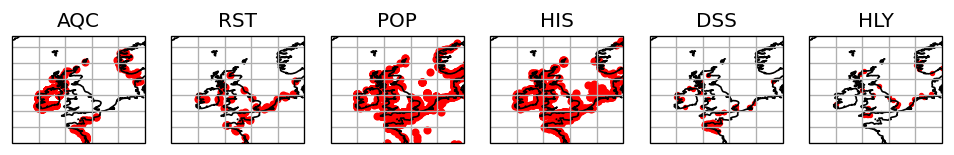

In [18]:
fig, ax = plt.subplots(1, 6, subplot_kw={"projection": cartopy.crs.PlateCarree()}, figsize=(10, 10))

fig.set_dpi(120)

df_aqc.plot.scatter(x="lon", y="lat", s=15, c="r", ax=ax.flatten()[0])
ax.flatten()[0].set_extent([-15, 10, 45, 65])
ax.flatten()[0].coastlines();
ax.flatten()[0].gridlines();
ax.flatten()[0].set_title("AQC");


df_rst.plot.scatter(x="lon", y="lat", s=15, c="r", ax=ax.flatten()[1])
ax.flatten()[1].set_extent([-15, 10, 45, 65])
ax.flatten()[1].coastlines();
ax.flatten()[1].gridlines();
ax.flatten()[1].set_title("RST");

df_pop.plot.scatter(x="lon", y="lat", s=15, c="r", ax=ax.flatten()[2])
ax.flatten()[2].set_extent([-15, 10, 45, 65])
ax.flatten()[2].coastlines();
ax.flatten()[2].gridlines();
ax.flatten()[2].set_title("POP");

df_his.plot.scatter(x="lon", y="lat", s=15, c="r", ax=ax.flatten()[3])
ax.flatten()[3].set_extent([-15, 10, 45, 65])
ax.flatten()[3].coastlines();
ax.flatten()[3].gridlines();
ax.flatten()[3].set_title("HIS");

df_dss.where(df_dss.infected).plot.scatter(x="lon", y="lat", c="r", s=5, ax=ax.flatten()[4])
ax.flatten()[4].set_extent([-15, 10, 45, 65])
ax.flatten()[4].coastlines();
ax.flatten()[4].gridlines();
ax.flatten()[4].set_title("DSS");

df_dss.where(~df_dss.infected).plot.scatter(x="lon", y="lat", c="r", s=5, ax=ax.flatten()[5])
ax.flatten()[5].set_extent([-15, 10, 45, 65])
ax.flatten()[5].coastlines();
ax.flatten()[5].gridlines();
ax.flatten()[5].set_title("HLY");

#df_sub.plot.scatter(x="lon", y="lat", s=15, c="r", ax=ax.flatten()[0])
#ax.flatten()[0].set_extent([-15, 10, 45, 65])
#ax.flatten()[0].coastlines();
#ax.flatten()[0].gridlines();
#ax.flatten()[0].set_title("SUB");

### Aggregate in hexes

In [19]:
df_hex_aqc = df_aqc.groupby("hex")["lat"].count().rename("aqc_count").to_frame()
df_hex_aqc.head(5)

,aqc_count
hex,
"(-1, -43, 44)",2
"(-1, -44, 45)",2
"(-10, 16, -6)",1
"(-10, 18, -8)",4
"(-10, 24, -14)",1


In [20]:
df_hex_pop = df_pop.groupby("hex")["lat"].count().rename("pop_count").to_frame()
df_hex_pop.head(5)

,pop_count
hex,
"(-1, -19, 20)",1
"(-1, -2, 3)",1
"(-1, -20, 21)",6
"(-1, -24, 25)",5
"(-1, -35, 36)",2


In [21]:
df_hex_rst = df_rst.groupby("hex")["lat"].count().rename("rst_count").to_frame()
df_hex_rst.head(5)

,rst_count
hex,
"(-10, -13, 23)",1
"(-11, 16, -5)",2
"(-11, 7, 4)",1
"(-14, -4, 18)",1
"(-14, 0, 14)",3


In [22]:
df_hex_dss = df_dss.where(df_dss.infected).dropna().groupby("hex")["lat"].count().rename("dss_count").to_frame()
df_hex_dss.head(5)

,dss_count
hex,
"(-1, -36, 37)",2
"(-1, -43, 44)",1
"(-1, -44, 45)",5
"(-10, -13, 23)",1
"(-10, -23, 33)",2


In [23]:
df_hex_hly = df_dss.where(~df_dss.infected).dropna().groupby("hex")["lat"].count().rename("hly_count").to_frame()
df_hex_hly.head(5)

,hly_count
hex,
"(-3, -25, 28)",1
"(-32, 3, 29)",1
"(-4, -17, 21)",1
"(-4, -25, 29)",1
"(-5, -24, 29)",1


In [24]:
df_hex_his = df_his.groupby("hex")["lat"].count().rename("his_count").to_frame()
df_hex_his.head(5)

,his_count
hex,
"(-1, -36, 37)",2
"(-1, -6, 7)",2
"(-1, 10, -9)",10
"(-1, 11, -10)",2
"(-1, 28, -27)",1


In [25]:
df_hex_agg = (
    df_hex_aqc
    .join(df_hex_rst, how="outer")
    .join(df_hex_pop, how="outer")
    .join(df_hex_dss, how="outer")
    .join(df_hex_hly, how="outer")
    .join(df_hex_his, how="outer")
    .fillna(0)
)
df_hex_agg.head(5)

,aqc_count,rst_count,pop_count,dss_count,hly_count,his_count
hex,,,,,,
"(-1, -19, 20)",0.0,0.0,1.0,0.0,0.0,0.0
"(-1, -2, 3)",0.0,0.0,1.0,0.0,0.0,0.0
"(-1, -20, 21)",0.0,0.0,6.0,0.0,0.0,0.0
"(-1, -24, 25)",0.0,0.0,5.0,0.0,0.0,0.0
"(-1, -35, 36)",0.0,0.0,2.0,0.0,0.0,0.0


### Add hex positions

In [26]:
df_hexes = pd.concat(
    (
        connectivity_matrix.hex0.rename("hex").to_dataframe(),
        connectivity_matrix.hex1.rename("hex").to_dataframe(),
    ),
    ignore_index=True,
)

df_hexes["lon"] = pd.concat(
    (
        connectivity_matrix.lon_hex0_corners.mean("corner").rename("lon").to_dataframe(),
        connectivity_matrix.lon_hex1_corners.mean("corner").rename("lon").to_dataframe(),
    ),
    ignore_index=True,
)

df_hexes["lat"] = pd.concat(
    (
        connectivity_matrix.lat_hex0_corners.mean("corner").rename("lat").to_dataframe(),
        connectivity_matrix.lat_hex1_corners.mean("corner").rename("lat").to_dataframe(),
    ),
    ignore_index=True,
)

df_hexes = df_hexes.sort_values("lon", ascending=False).drop_duplicates().set_index("hex")

df_hexes

,lon,lat
hex,,
"(51, 3, -54)",10.144729,58.282184
"(50, 7, -57)",10.091668,58.841069
"(51, 2, -53)",10.088256,58.129718
"(50, 6, -56)",10.034246,58.688578
"(50, 5, -55)",9.977396,58.536061
...,...,...
"(-58, 26, 32)",-16.114050,53.307225
"(-48, 66, -18)",-16.114648,60.421327
"(-47, 70, -23)",-16.124761,61.132994


In [27]:
df_hex_agg = df_hex_agg.join(df_hexes, how="outer").dropna()
df_hex_agg.head(5)

,aqc_count,rst_count,pop_count,dss_count,hly_count,his_count,lon,lat
hex,,,,,,,,
"(-1, -19, 20)",0.0,0.0,1.0,0.0,0.0,0.0,-3.195231,51.464537
"(-1, -2, 3)",0.0,0.0,1.0,0.0,0.0,0.0,-3.207510,54.110755
"(-1, -20, 21)",0.0,0.0,6.0,0.0,0.0,0.0,-3.194563,51.308807
"(-1, -24, 25)",0.0,0.0,5.0,0.0,0.0,0.0,-3.191945,50.685789
"(-1, -35, 36)",0.0,0.0,2.0,0.0,0.0,0.0,-3.185172,48.971542


### Visualize

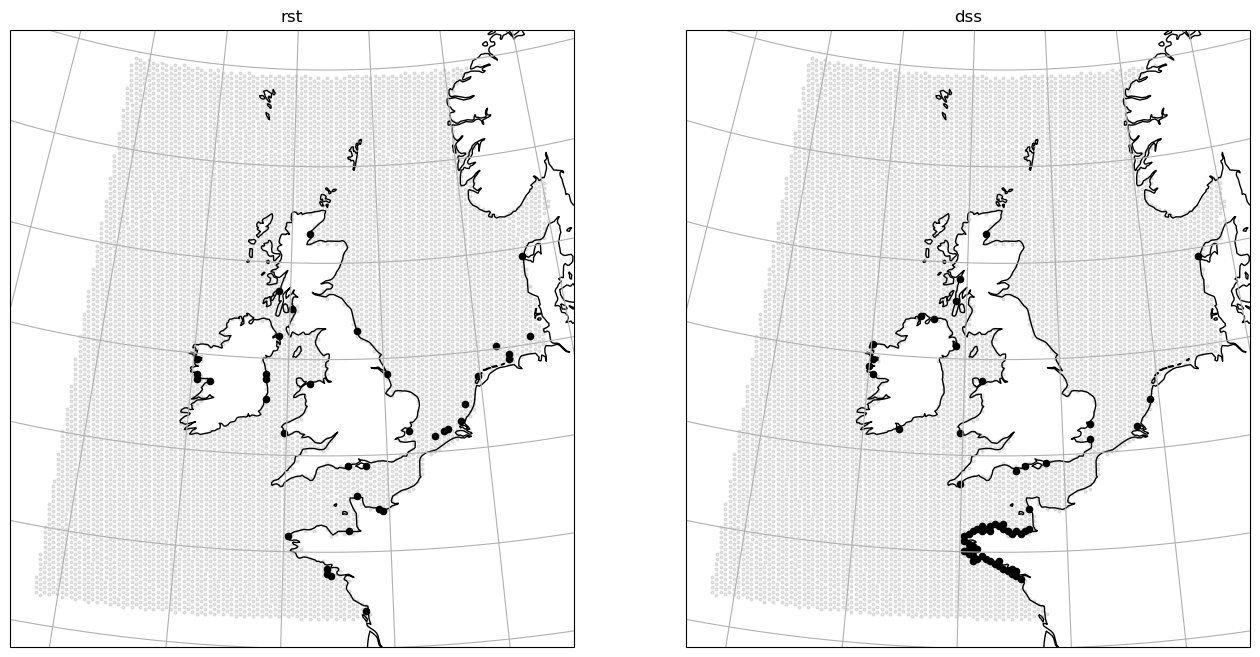

In [28]:
fig, ax = plt.subplots(
    1, 2, 
    subplot_kw={"projection": cartopy.crs.Stereographic(central_latitude=lat_origin, central_longitude=lon_origin)},
    figsize=(16, 12),
    # sharex=True, sharey=True,
)

for _tp, _ax in zip(["rst", "dss"], ax.flatten()):
    df_hexes.plot.scatter(x="lon", y="lat", c="gray", s=4, zorder=-10, ax=_ax, alpha=0.2, transform=cartopy.crs.PlateCarree())
    _df = df_hex_agg.where(df_hex_agg[f"{_tp}_count"] > 0).dropna()
    _df.plot.scatter(x="lon", y="lat", c="black", s=20, ax=_ax, transform=cartopy.crs.PlateCarree())
    _ax.coastlines();
    _ax.gridlines();
    _ax.set_title(_tp);

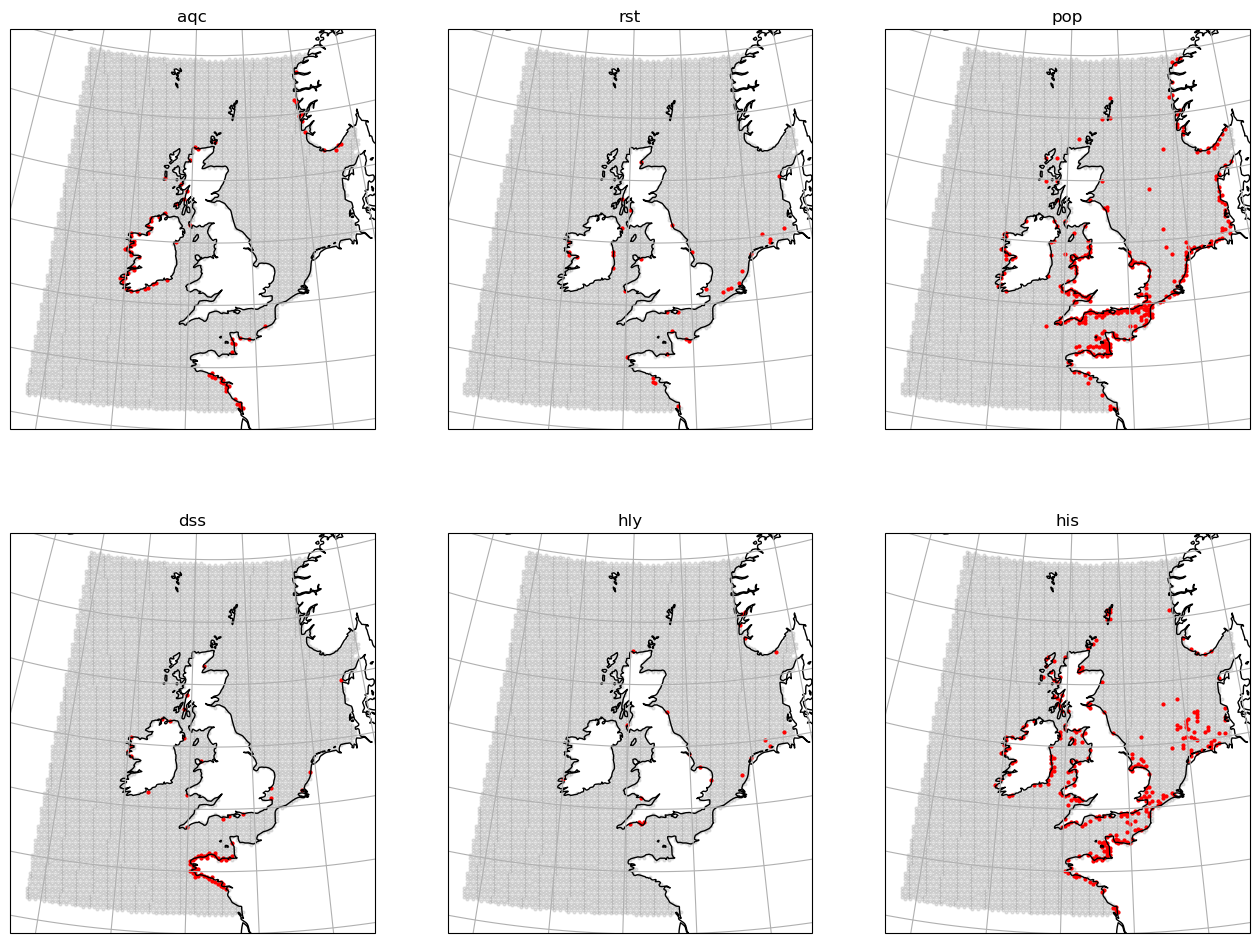

In [29]:
fig, ax = plt.subplots(
    2, 3, 
    subplot_kw={"projection": cartopy.crs.Stereographic(central_latitude=lat_origin, central_longitude=lon_origin)},
    figsize=(16, 12),
    # sharex=True, sharey=True,
)

for _tp, _ax in zip(["aqc", "rst", "pop", "dss", "hly","his"], ax.flatten()):
    df_hexes.plot.scatter(x="lon", y="lat", c="gray", s=4, zorder=-10, ax=_ax, alpha=0.2, transform=cartopy.crs.PlateCarree())
    _df = df_hex_agg.where(df_hex_agg[f"{_tp}_count"] > 0).dropna()
    _df.plot.scatter(x="lon", y="lat", c="red", s=4, ax=_ax, transform=cartopy.crs.PlateCarree())
    _ax.coastlines();
    _ax.gridlines();
    _ax.set_title(_tp);

## Add connectivity

In [30]:
import tqdm
from copy import deepcopy

In [31]:
for dt, cmf in tqdm.tqdm(enumerate(connectivity_matrix_file_list)):

    keep_attrs = deepcopy(connectivity_matrix.attrs)
    
    connectivity_matrix = xr.open_dataset(cmf)
     
    connectivity_matrix = xr.merge(
        (
            df_hex_agg.drop(columns=["lon", "lat"]).add_suffix("_hex0").to_xarray().rename({"hex": "hex0"}),
            df_hex_agg.drop(columns=["lon", "lat"]).add_suffix("_hex1").to_xarray().rename({"hex": "hex1"}),
            connectivity_matrix,
        )
    ).fillna(0)
    
    connectivity_matrix = connectivity_matrix.assign_coords(
        lon_hex0=connectivity_matrix.lon_hex0_corners.isel(corner=slice(0, 6)).mean("corner"),
        lon_hex1=connectivity_matrix.lon_hex1_corners.isel(corner=slice(0, 6)).mean("corner"),
        lat_hex0=connectivity_matrix.lat_hex0_corners.isel(corner=slice(0, 6)).mean("corner"),
        lat_hex1=connectivity_matrix.lat_hex1_corners.isel(corner=slice(0, 6)).mean("corner"),
    )
    
    #not sure where we lost these ....
    connectivity_matrix = connectivity_matrix.assign_attrs(keep_attrs)
    
    #new_file_name = cmf.name.split(".")[0] + "_bio_agg.nc"

    #connectivity_matrix.compute().to_netcdf(cmf.parents[0] / new_file_name)

    connectivity_matrix_file_out = Path(connectivity_matrix_file_out_path)/connectivity_matrix_file_out_pattern.format(dt=dt)
    
    connectivity_matrix.compute().to_netcdf(connectivity_matrix_file_out)
    
    connectivity_matrix.close()

0it [00:00, ?it/s]

29it [11:30, 23.80s/it]
